# Загрузка библиотек и данных

In [1]:
from IPython.display import display, HTML
display(HTML('<style>.container {width:80%}</style>'))
import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

In [2]:
"""%%capture
!pip install -U catboost
!pip install -U xgboost""";

In [3]:
import numpy as np
import pandas as pd
import itertools
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale = 1.5)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

RS = 100500 # random state

In [4]:
df = pd.read_csv('D:/Data/Projects/Kaggle_workshop/train.csv')
display(df.head())
display(df.info())

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


None

# EDA

In [5]:
# Эта функция используется для предобработки (!) только на этапе исследовательского анализа
# Для предобработки тренировочной и тестовой выборок далее будет использована более полная функция
def pre_processing_1st_step(data=df):
    age = np.floor(data.age / 365.25)
    gender = data.gender.replace(2, 0)
    
    return {'age': age, 'gender': gender}
    

df.age = pre_processing_1st_step()['age']
df.gender = pre_processing_1st_step()['gender']

### Рост и возраст

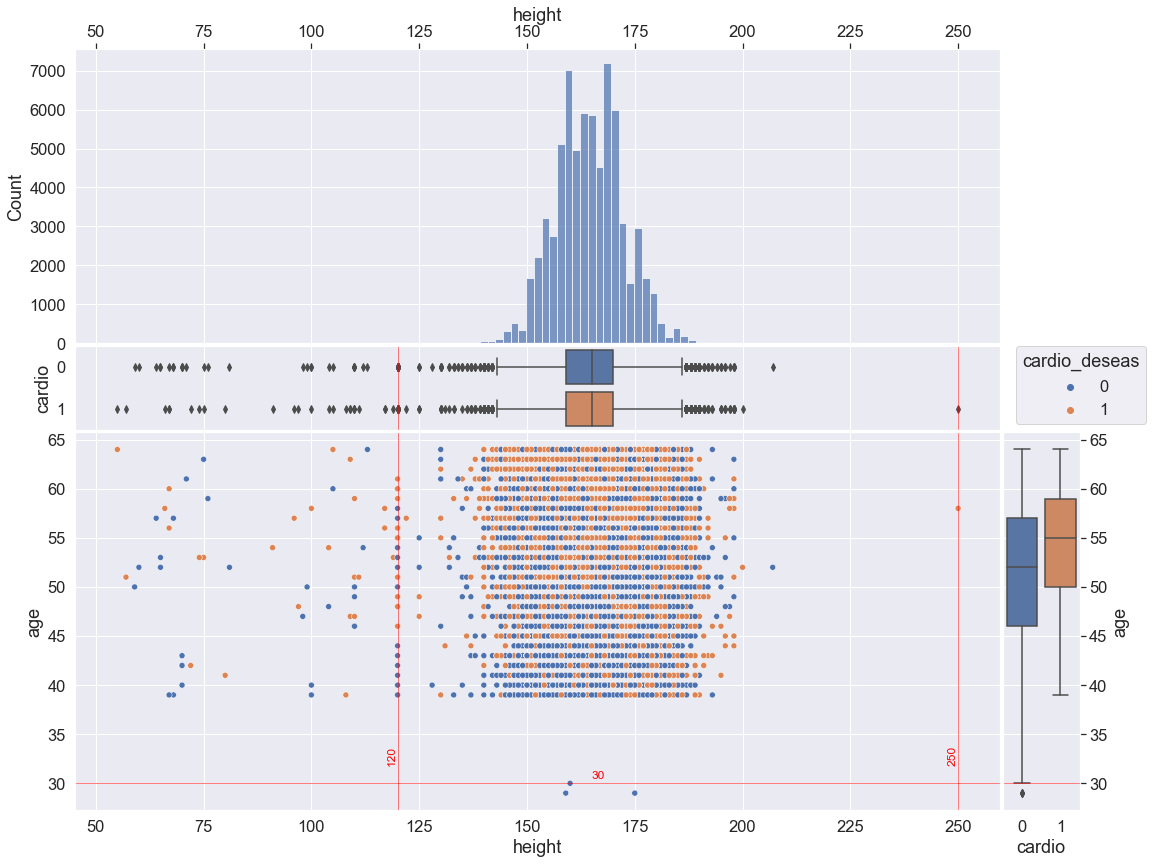

In [6]:
fig, ax = plt.subplots(3, 2, figsize=(18, 14), gridspec_kw={'height_ratios': [7, 2, 9], 'width_ratios' : [12, 1]})
fig.delaxes(ax[0, 1]) 
fig.delaxes(ax[1, 1])

sns.histplot(df, x='height', alpha=.7, bins=df.height.nunique(), ax=ax[0, 0])
sns.boxplot(data=df, x='height', y='cardio', orient='h', ax=ax[1, 0])
sns.boxplot(data=df, y='age', x='cardio', ax=ax[2, 1])
sns.scatterplot(data=df, x='height', y='age', hue='cardio',ax=ax[2, 0])

anomaly_1 = df[df['height'] < 125]['height'].value_counts().head(1).keys()[0]
anomaly_2 = df['height'].max()
ax[2, 0].axvline(anomaly_1, c='red', lw=.5)
ax[1, 0].axvline(anomaly_1, c='red', lw=.5)
ax[2, 0].axvline(anomaly_2, c='red', lw=.5)
ax[1, 0].axvline(anomaly_2, c='red', lw=.5)
ax[2, 0].axhline(30, c='red', lw=.5)
ax[2, 1].axhline(30, c='red', lw=.5)
ax[0, 0].xaxis.tick_top()
ax[2, 1].yaxis.tick_right()
ax[0, 0].xaxis.set_label_position('top') 
ax[2, 1].yaxis.set_label_position('right') 
ax[2, 0].legend(bbox_to_anchor=(1.167, 1.25), title='cardio_deseas')

plt.sca(ax[2, 0])
plt.text(anomaly_1 - 2.5, 32, anomaly_1, rotation=90, size=12, c='red')
plt.text(anomaly_2 - 2.5, 32, anomaly_2, rotation=90, size=12, c='red')
plt.text(165, 30.5, 30, rotation=0, size=12, c='red')
plt.subplots_adjust(hspace = .01, wspace = .005)
plt.show()
plt.close()

В категории `height` (рост) наблюдаются аномалии. Их связь с детским возрастом пациентов не подтвердилась, это люди самых разных возрастов.
С учётом того, что в выборке могли оказаться пациенты с диагнозом "карликовость" (МКБ: E34.3, рост ниже 143 см), предусмотрим возможность *мягкой* отсечки аномалий.
В зоне аномалий наблюдается особенно много значений роста равных **120 см**. Это и будем считаь границей аномалий **включительно**.   

Также исключим явно аномальный рост равный **250 см** (на момент исследования на Земле живёт лишь один человек с таким ростом).  

В категории `age` - возраст пациентов ниже **30 лет** включительно не является аномалией как таковой. Однако, учитывая крайне малое количество пациентов в данной возрастнйо группе, также предусмотрим возможность её исключения.   

---

В рамках исследовательского анализа **не прослеживается** зависимости наличия сердечных заболеваний **от роста**.   

Однако **прослеживается** зависимость **от возраста** - пациенты более старшего возраста чаще подвержены сердечным заболеваниям. 



### Вес

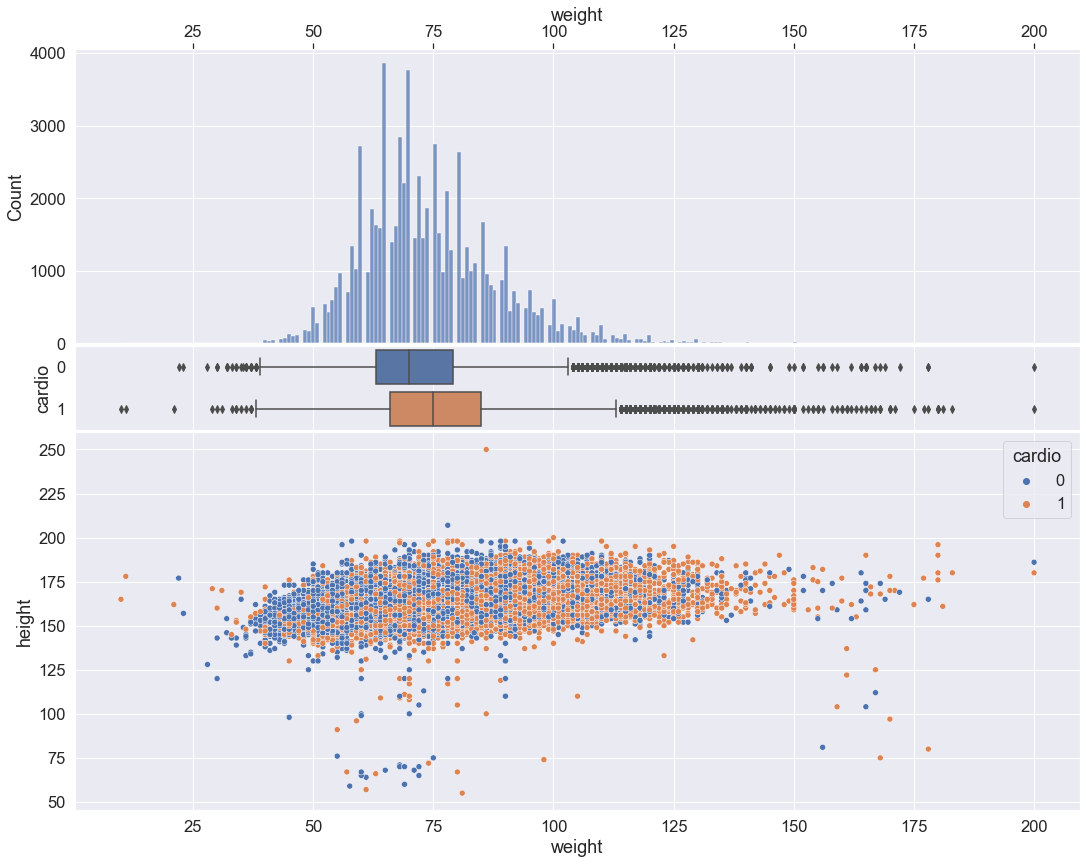

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(18, 14),
                       gridspec_kw={'height_ratios': [7, 2, 9]})

sns.histplot(df, x='weight', alpha=.7, bins='auto', ax=ax[0])
sns.boxplot(data=df, x='weight', y='cardio', orient='h', ax=ax[1])
sns.scatterplot(data=df, x='weight', y='height', hue='cardio',ax=ax[2])

ax[0].xaxis.tick_top()
ax[0].xaxis.set_label_position('top') 
plt.subplots_adjust(hspace = .01)
plt.show()
plt.close()

**Высокие** показатели категории `weight` (вес) нельзя считать аномальными. В то же время в выборке присутствуют **крайне низкие** показатели веса, не характерные для взрослых людей. Ярко выраженной границы аномалий нет. Предусмотрим возможность их отсечения по левой границе диаграмы размаха.  


---

Прослеживается *зависимость** диагностирования срдечных заболеваний от наличия **изличшей массы** тела.

### Индекс массы тела (ИМТ)
Создадим синтетический признак на основе признаков веса и роста пациентов.

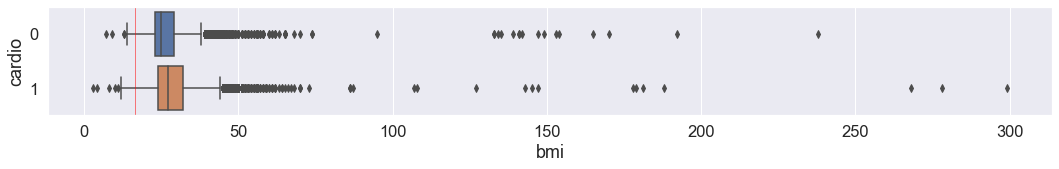

In [8]:
df['bmi'] = np.round(df.weight / (df.height / 100) ** 2)

fig, ax = plt.subplots(figsize=(18, 2))
sns.boxplot(data=df, x='bmi', y='cardio', orient='h')
ax.axvline(16.5, c='red', lw=.5)
plt.show()
plt.close()

<font color="red">Красной линией</font> отмечена граница критически **низкого индекса массы тела**. Учитывая, что левая граница диаграмы размаха ниже этого значения, при ограничении выборки будем ориентироваться именно на диаграмму размаха. Значения индекса массы тела **выше 50** возможны, однако можно рассмотреть возможность признания аномальными значения **выше 100**.  

----

Индекс массы тела также показывает повышенную вероятность возникновения сердечных заболеваний у тех, у кого он завышен.

### Артериальное давление
Для наглядности на втором графике увеличим основную область диаграмы размаха.

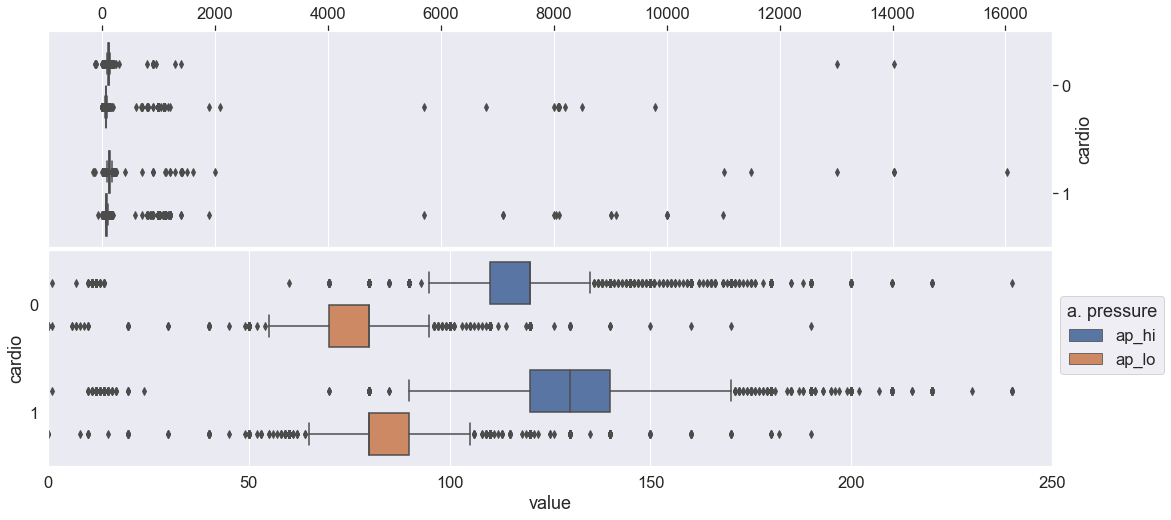

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(18, 8))

sns.boxplot(y='cardio', x='value',
            hue='variable', orient='h',
            data=pd.melt(df, id_vars=['cardio'], value_vars=['ap_hi', 'ap_lo']),
            ax=ax[0])
sns.boxplot(y='cardio', x='value',
            hue='variable', orient='h',
            data=pd.melt(df, id_vars=['cardio'], value_vars=['ap_hi', 'ap_lo']),
            ax=ax[1])

ax[0].yaxis.tick_right()
ax[0].xaxis.tick_top()
ax[0].yaxis.set_label_position('right')
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1, .39), title='a. pressure')

plt.sca(ax[1])
plt.xlim([0, 250])
plt.subplots_adjust(hspace = .015)
plt.show()
plt.close()

В категории данных `ap_hi` и `ap_lo` (артериальное давление) есть аномальные, очень значительные выбросы. Часть из них легко упорядочить: например систолитическое (верхнее) давление с явно **ошибочными** показаниями от **~11000 до ~16000** явно соответствует реальным **110 - 160**. А **ошибочные** показания в диапазоне **от ~6000 до ~8000** явно соответствуют диапазону дистолитического (нижнего) **60-100**.    

В то же время сделать предположения о природе выбросов в диапазоне **от 250 до ~2000+** сложнее. Вряд ли проблема в лишних нулях. Иначе систолитическое давление 500 мм. рс. превращалось бы в 50. Эти выбросы могут быть отредактированы.   

Выбросы в нижней (левой) области диаграмы систолитического значения - предположительно связаны с тем, что к значению напротив не добавлена необходимая цифра 0. Эти значения также можно восстановить. Однако крайне-низкие показатели дистолитического давления также вызывают сомнения. Давление до нуля возможно, однако это чаще всего связано с состояниями, близкими к смерти человека.

----

Прослеживается зависимость наличия сердечных заболеваний от повышенного давления.

### Нечисловые признаки

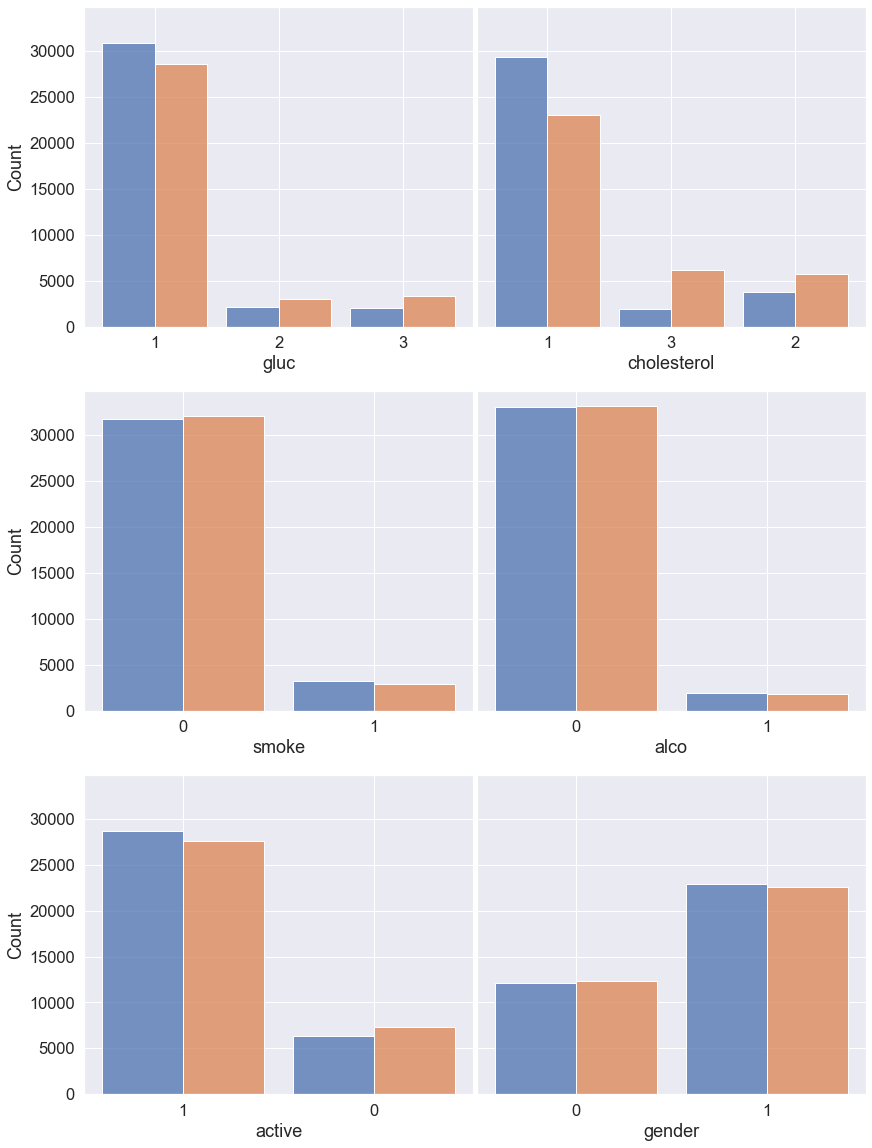

In [10]:
fig, ax = plt.subplots(3, 2, figsize=(14, 20), sharey=True)

for position, column in zip(itertools.product(range(3), range(2)),
                            ['gluc', 'cholesterol', 'smoke', 'alco', 'active', 'gender']):
    sns.histplot(x=df[column].astype('str'), hue=df['cardio'],
                 multiple='dodge', legend=False, shrink=.85, ax=ax[position])
    
plt.subplots_adjust(wspace = .01)
plt.show()

Высокий уровень холестирина, сахара в крови и сниженная активность - чаще встречаются у пациентов с болезнями сердца.

# Очистка данных

Функция для повторного получения и очистки данных (пороги преобразований могут быть изменены на отличные от описанных в разделе EDA).

In [11]:
def get_propper_data(train_or_test='train'):
    #data = pd.read_csv(f'/kaggle/input/yap4-heart-diseases-prediction/{train_or_test}.csv')
    data = pd.read_csv(f'D:/Data/Projects/Kaggle_workshop/{train_or_test}.csv')
    len_data = len(data)
    # возраст в годах
    data['age'] = np.floor(data['age'] / 365.25)  # возраст в годах
    data['gender'] = data['gender'].replace(2, 0)  # пол 2 (женщины) переводится в 0
    
    # устанение выбросов возраста
    data.loc[data['age'] < data['age'].quantile(.025), 'age'] = data['age'].quantile(.25) - 1
    data.loc[data['age'] > data['age'].quantile(.975), 'age'] = data['age'].quantile(.75) + 1
    
    # служебные категории веса и роста
    data['w_category'] = pd.qcut(data['weight'], 8, labels=False)
    data['h_category'] = pd.qcut(data['height'], 8, labels=False)    
    weight_group = data.groupby('h_category', as_index=False).agg({'weight': 'median'})
    height_group = data.groupby('w_category', as_index=False).agg({'height': 'median'})
    
    # служебные колонки среднего веса и роста
    data = (data.merge(weight_group, on='h_category', how='left', suffixes=['', '_avg'])
            .merge(height_group, on='w_category', how='left', suffixes=['', '_avg']))
    
    # приведение аномальных значений роста и веса к норме
    data.loc[(data['height'] < 130) | (data['height'] > 210), 'height'] = data['height_avg']
    data.loc[(data['weight'] < 40) | (data['weight'] > 180), 'weight'] = data['weight_avg']    
    data['bmi'] = np.round(data.weight / (data.height / 100) ** 2)  # создание колонки ИМТ  
    
    #повторное приведение значений к норме с помощью колонки ИМТ
    data.loc[data['bmi'] < 14, 'weight'] = data['weight_avg']
    data.loc[data['bmi'] > 70, 'weight'] = data['weight_avg']
    data.loc[data['bmi'] < 14, 'height'] = data['height_avg']
    data.loc[data['bmi'] > 70, 'height'] = data['height_avg']   
    data['bmi'] = np.round(data.weight / (data.height / 100) ** 2)  # повторное создание колонки ИМТ  
    
    # первичное устранение аномалий давления
    data.loc[data['ap_hi'] < 0, 'ap_hi'] = abs(data['ap_hi'])
    data.loc[data['ap_lo'] < 0, 'ap_lo'] = abs(data['ap_lo'])
    data.loc[(data['ap_hi'] > 8000) &
             (data['ap_hi'] < 31000), 'ap_hi'] = np.round(data['ap_hi'] / 100, 0)
    data.loc[(data['ap_hi'] > 800) &
             (data['ap_hi'] < 3100), 'ap_hi'] = np.round(data['ap_hi'] / 10, 0)
    data.loc[(data['ap_hi'] >= 8) & (data['ap_hi'] <= 31), 'ap_hi'] = data['ap_hi'] * 10    
    data.loc[(data['ap_lo'] > 4000) &
             (data['ap_lo'] < 22000), 'ap_lo'] = np.round(data['ap_lo'] / 100, 0)
    data.loc[(data['ap_lo'] > 400) &
             (data['ap_lo'] < 2200), 'ap_lo'] = np.round(data['ap_lo'] / 10, 0)
    data.loc[(data['ap_lo'] >= 4) & (data['ap_lo'] <= 22), 'ap_lo'] = data['ap_lo'] * 10
    
    # служебные колонки для давления
    data['bmi_category'] = pd.qcut(data['bmi'], 6, labels=False)
    ap_hi_group = data.groupby('bmi_category', as_index=False).agg({'ap_hi': 'median'})
    ap_lo_group = data.groupby('bmi_category', as_index=False).agg({'ap_lo': 'median'})
    data = (data.merge(ap_hi_group, on='bmi_category', how='left', suffixes=['', '_avg'])
            .merge(ap_lo_group, on='bmi_category', how='left', suffixes=['', '_avg']))
    
    # вторичное устранение аномалий давления
    data['ap_dif'] = data['ap_hi'] - data['ap_lo']    
    data.loc[(data['ap_hi'] > 310) | (data['ap_hi'] < 80) |
             (data['ap_dif'] < 10) | (data['ap_dif'] > 120), 'ap_hi'] = data['ap_hi_avg']    
    data.loc[(data['ap_lo'] > 220) | (data['ap_lo'] < 40) |
             (data['ap_dif'] < 10) | (data['ap_dif'] > 120), 'ap_lo'] = data['ap_lo_avg']    
    
    return data.drop(['w_category', 'h_category', 'weight_avg',
                      'height_avg', 'bmi', 'bmi_category', 'ap_hi_avg', 'ap_lo_avg', 'ap_dif'], axis=1)

train = get_propper_data('train')
display(train.sort_values(['ap_lo', 'ap_hi'], ascending=False))
display(train.describe().T)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
52851,75399,48.0,0,164,64.0,240,200,3,1,0,0,1,1
38022,54282,59.0,1,161,84.0,196,182,2,2,0,0,1,1
43998,62861,62.0,0,163,70.0,200,180,1,1,0,0,0,1
4781,6769,51.0,1,158,74.0,200,170,1,1,0,0,1,1
31315,44701,62.0,1,163,115.0,200,170,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11951,17067,43.0,0,160,52.0,120,40,1,1,1,0,1,0
28742,41083,53.0,1,139,61.0,120,40,1,1,0,0,1,0
45951,65633,42.0,1,158,47.0,120,40,1,1,0,0,1,0
33046,47217,57.0,1,149,54.0,90,40,1,1,0,0,1,0


,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,52.804271,6.760259,39.0,48.00,53.0,58.00,64.0
gender,70000.0,0.650429,0.476838,0.0,0.00,1.0,1.00,1.0
height,70000.0,164.440471,7.853634,130.0,159.00,165.0,170.00,207.0
weight,70000.0,74.223541,14.322907,40.0,65.00,72.0,82.00,180.0
ap_hi,70000.0,127.043243,16.990084,80.0,120.00,120.0,140.00,240.0
ap_lo,70000.0,81.578471,9.717430,40.0,80.00,80.0,90.00,200.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


Аномалии устранены без удаления строк, содержащих отклонения значений.

# Преобразование признаков

Проверим корреляции признаков (проверяем её на данном этапе так как уже зачищены выбросы значений, что положительно скажется на показаниях корр-матрицы)

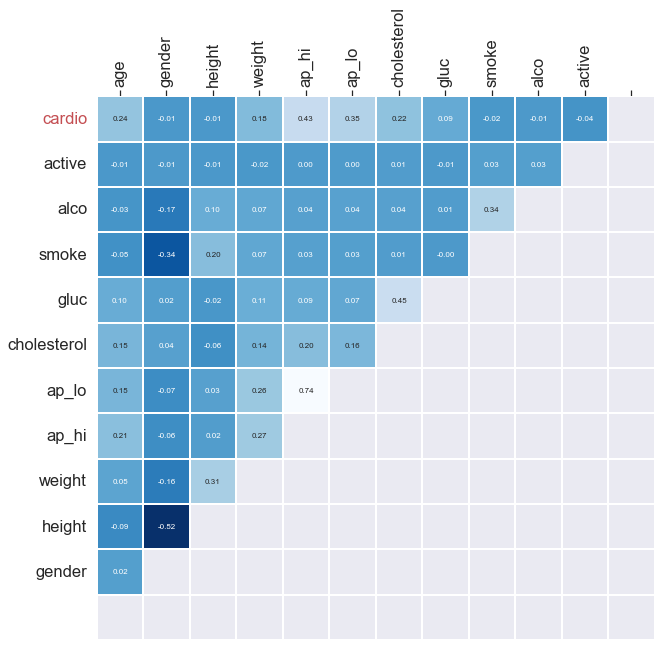

In [12]:
plt.figure(figsize=(10, 10))
corr = train.drop('id', axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype='bool'))

ax = sns.heatmap(corr, linewidths=2, annot=True, mask=mask,
                 annot_kws={'size': 8}, fmt='.2f', cbar=False, cmap='Blues_r')

ax.xaxis.tick_top()
ax.yaxis.get_ticklabels()[11].set_color('r')
ax.yaxis.get_ticklabels()[0].set_color('w')
ax.xaxis.get_ticklabels()[11].set_color('w')
ax.invert_yaxis()

plt.xticks(rotation=90)
plt.show()
plt.close()

Больше всего наблюдения сердечных заболваний корелируют с повышенным **артериальным давлением**. Также слабая корреляция наблюдается с **возрастом**, **хлестирином**, повышенным **весом**. 

In [13]:
train.cardio.value_counts(normalize=True)

0    0.5003
1    0.4997
Name: cardio, dtype: float64

Баланс классов идеальный, ресемплирование не требуется.  


Создадим функцию для формирования дополнительных признаков (индекс массы тела, разность давления, признаки "плохого состояния" и "здоровья" организма)

In [14]:
def feature_engineering(data_type='train', additional_features='on'):
    data = get_propper_data(data_type)
    
    if additional_features == 'off':
        return data
    
    if additional_features == 'on':
        
        data['bmi'] = round(data['weight'] / ((data['height'] / 100) ** 2))
        data['ap_dif'] = data['ap_hi'] - data['ap_lo']        
        data['bad_condition'] = ((data['bmi'] >= 35) + data['cholesterol'] + data['gluc']).replace([2, 3, 4, 5, 6, 7], [0, 0, 1, 1, 1, 1])
        data['good_habits'] = (data['alco'].replace([0, 1], [1, 0]) + data['smoke'].replace([0, 1], [1, 0]) + data['active']).replace([0, 1, 2, 3], [0, 0, 0, 1])        
        return data

In [15]:
feature_engineering(data_type='train', additional_features='on')

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,ap_dif,bad_condition,good_habits
0,0,50.0,0,168,62.0,110,80,1,1,0,0,1,0,22.0,30,0,1
1,1,55.0,1,156,85.0,140,90,3,1,0,0,1,1,35.0,50,1,1
2,2,51.0,1,165,64.0,130,70,3,1,0,0,0,1,24.0,60,1,0
3,3,48.0,0,169,82.0,150,100,1,1,0,0,1,1,29.0,50,0,1
4,4,47.0,1,156,56.0,100,60,1,1,0,0,0,0,23.0,40,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,52.0,0,168,76.0,120,80,1,1,1,0,1,0,27.0,40,0,0
69996,99995,61.0,1,158,126.0,140,90,2,2,0,0,1,1,50.0,50,1,1
69997,99996,52.0,0,183,105.0,180,90,3,1,0,1,0,1,31.0,90,1,0
69998,99998,61.0,1,163,72.0,135,80,1,2,0,0,0,1,27.0,55,0,0


Создадим функцию для стандартизации признаков.
(это комплексная функция, которая будет масштабировать и кодировать признаки разными типами. Эти разные типы стандартизации будут использованы для подбора гиперпараметров и обучения разных моделей)

In [16]:
def transformation(transform_type, data_type, additional_features):
    data = feature_engineering(data_type=data_type, additional_features=additional_features)
    
    if transform_type == 'type1':
        if additional_features == 'on':
            standartization_columns = ['age', 'height', 'weight',
                                    'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'bmi', 'ap_dif']
        else:
            standartization_columns = ['age', 'height', 'weight',
                                    'ap_hi', 'ap_lo', 'cholesterol', 'gluc']
        
        scaler = StandardScaler()
        scaler.fit(data[standartization_columns])    
        scaled_data = scaler.transform(data[standartization_columns])
        
        if additional_features == 'on':
            X_data = pd.DataFrame(columns=standartization_columns, data=scaled_data,
                                  index=data.index).join(data[['gender', 'smoke', 'alco', 'active', 'bad_condition', 'good_habits']])
        else:
            X_data = pd.DataFrame(columns=standartization_columns, data=scaled_data,
                                  index=data.index).join(data[['gender', 'smoke', 'alco', 'active']])
        
    if transform_type == 'type2':
        if additional_features == 'on':
            standartization_columns = ['age', 'height', 'weight',
                                        'ap_hi', 'ap_lo', 'bmi', 'ap_dif']
        else:
            standartization_columns = ['age', 'height', 'weight',
                                        'ap_hi', 'ap_lo']
         
        reg_columns = pd.get_dummies(df['cholesterol'],
                                     prefix='cholesterol_',
                                     drop_first=True).join(pd.get_dummies(df['gluc'],
                                                                          prefix='gluc_',
                                                                          drop_first=True))        
        scaler = StandardScaler()
        scaler.fit(data[standartization_columns])    
        scaled_data = scaler.transform(data[standartization_columns])
        
        if additional_features == 'on':
            X_data = (pd.DataFrame(columns=standartization_columns,
                              data=scaled_data, index=data.index)
                  .join(reg_columns)
                  .join(data[['gender', 'smoke', 'alco', 'active', 'bad_condition', 'good_habits']]))
            
        else:
            X_data = (pd.DataFrame(columns=standartization_columns,
                              data=scaled_data, index=data.index)
                  .join(reg_columns)
                  .join(data[['gender', 'smoke', 'alco', 'active']]))
            
    if transform_type == 'type3':
        if additional_features == 'on':
            standartization_columns = ['age', 'height', 'weight',
                                        'ap_hi', 'ap_lo', 'bmi', 'ap_dif']
        else:
            standartization_columns = ['age', 'height', 'weight',
                                        'ap_hi', 'ap_lo']
            
        scaler = StandardScaler()
        scaler.fit(data[standartization_columns])    
        scaled_data = scaler.transform(data[standartization_columns])
        
        if additional_features == 'on':
            X_data = pd.DataFrame(columns=standartization_columns,
                              data=scaled_data, index=data.index).join(data[['cholesterol', 'gluc', 'gender', 'smoke', 'alco', 'active', 'bad_condition', 'good_habits']])
        else:
            X_data = pd.DataFrame(columns=standartization_columns,
                              data=scaled_data, index=data.index).join(data[['cholesterol', 'gluc', 'gender', 'smoke', 'alco', 'active']])
    
    
    if transform_type == 'type4':
        X_data = data.drop('cardio', axis=1)
        
    if data_type == 'train':
        return X_data, data['cardio']
    else:
        return X_data, None

## Подбор гиперпараметров

<div class="alert alert-info">Уважаемый читатель, этот раздел точно не стоит принимать за best practices. Варианты гиперпараметров скармливались гридсёрчу в разных комбинациях множество раз, и то, что присутствует в коде ниже - лишь заключительная точка каждого из этапов, но отнюдь не пример для подражания. </div>

Помимо, собственно, подбора гиперпараметров - в этом разделе подбираются подходящие способы стандартизации данных и наборы дополнительных признаков. Я перевёл код в маркдаун, чтобы он не отрабатывал - и оставался просто для ознакомления.

```python

# CatBoost
CBC_params = {}
CBC_params['loss_function'] = ['Logloss']
CBC_params['iterations'] = [75, 80, 85]
CBC_params['random_seed'] = [RS]
CBC_params['learning_rate'] = [0.1, 0.15, 0.2, 0.25]
CBC_params['depth'] = [6]
start_time = time.time()

CBC = CatBoostClassifier()

base_score = 0
data_type = 0
mode = 0
params = {}

for t in ['type1', 'type4']:
    for f in ['on']:
        local_data = transformation(transform_type=t, data_type='train', additional_features=f)
        X_train = local_data[0]
        y_train = local_data[1]
        Grid_CBC = GridSearchCV(estimator=CBC, param_grid = CBC_params, scoring='roc_auc', cv = 4, n_jobs=-1, verbose=1)
        Grid_CBC.fit(X_train, y_train, verbose=False)
        if Grid_CBC.best_score_ > base_score:
            base_score = Grid_CBC.best_score_
            data_type = t
            mode = f
            params = Grid_CBC.best_params_

print()
print("\n The best score:\n", base_score)
print("\n The best parameters:\n", params)
print(data_type, mode)
print('time ', time.time() - start_time)

# -----------------------------------------------------
# LogRegression
LR_params = {}
LR_params['penalty'] = ['l1']
LR_params['random_state'] = [RS]
LR_params['solver'] = ['saga']
LR_params['C'] = [.1, .125, .15, .2]

start_time = time.time()

LR =  LogisticRegression()

base_score = 0
data_type = 0
mode = 0
params = {}

for t in ['type2']:
    for f in ['on']:
        local_data = transformation(transform_type=t, data_type='train', additional_features=f)
        X_train = local_data[0]
        y_train = local_data[1]
        Grid_LR = GridSearchCV(estimator=LR, scoring='roc_auc', param_grid = LR_params, cv = 4, n_jobs=-1)
        Grid_LR.fit(X_train, y_train)
        if Grid_LR.best_score_ > base_score:
            base_score = Grid_LR.best_score_
            data_type = t
            mode = f
            params = Grid_LR.best_params_

print()
print("\n The best score:\n", base_score)
print("\n The best parameters:\n", params)
print(data_type, mode)
print('time ', time.time() - start_time)

RFR_params = {}
RFR_params['criterion'] = ['gini', 'entropy']
RFR_params['n_estimators'] = [100, 110, 120, 130, 140]
RFR_params['random_state'] = [RS]
RFR_params['max_depth'] = [10, 11, 12, 13]
RFR_params['min_samples_leaf'] = [1, 2, 3]

# -----------------------------------------------------
# RandomForest

RFR_params = {}
RFR_params['criterion'] = ['gini', 'entropy']
RFR_params['n_estimators'] = [100, 110, 120, 130, 140]
RFR_params['random_state'] = [RS]
RFR_params['max_depth'] = [10, 11, 12, 13]
RFR_params['min_samples_leaf'] = [1, 2, 3]

RFR =  RandomForestClassifier()

base_score = 0
data_type = 0
mode = 0
params = {}

for t in ['type1', 'type2', 'type4']:
    for f in ['on', 'off']:
        local_data = transformation(transform_type=t, data_type='train', additional_features=f)
        X_train = local_data[0]
        y_train = local_data[1]
        Grid_RFR = GridSearchCV(estimator=RFR, param_grid = RFR_params, scoring='roc_auc', cv = 4, n_jobs=-1)
        Grid_RFR.fit(X_train, y_train)
        if Grid_RFR.best_score_ > base_score:
            base_score = Grid_RFR.best_score_
            data_type = t
            mode = f
            params = Grid_RFR.best_params_
            
print()
print("\n The best score:\n", base_score)
print("\n The best parameters:\n", params)
print(data_type, mode)

#-------------------------------------
#XGBoost

XGB_params = {}
XGB_params['objective'] = ['binary:logistic']
XGB_params['random_state'] = [RS]
XGB_params['learning_rate'] = [0.04]
XGB_params['max_depth'] = [5]
XGB_params['min_child_weight'] = [12]
XGB_params['subsample'] = [0.7]
XGB_params['colsample_bytree'] = [0.8]
XGB_params['n_estimators'] = [180]

XGB =  xgb.XGBClassifier()

base_score = 0
data_type = 0
mode = 0
params = {}

for t in ['type1', 'type4']:
    for f in ['on', 'off']:
        local_data = transformation(transform_type=t, data_type='train', additional_features=f)
        X_train = local_data[0]
        y_train = local_data[1]
        Grid_XGB = GridSearchCV(estimator=XGB, param_grid = XGB_params, scoring='roc_auc', cv = 4, n_jobs=-1)
        Grid_XGB.fit(X_train, y_train)
        if Grid_XGB.best_score_ > base_score:
            base_score = Grid_XGB.best_score_
            data_type = t
            mode = f
            params = Grid_XGB.best_params_

print()
print("\n The best score:\n", base_score)
print("\n The best parameters:\n", params)
print(data_type, mode)

#-------------------------------------
#KNeighbors

KNC_params = {}
KNC_params['n_neighbors'] = [370]
KNC_params['leaf_size'] = [4]
start_time = time.time()

KNC = KNeighborsClassifier()

base_score = 0
data_type = 0
mode = 0
learning_rate = 0
max_depth = 0
min_child_weight = 0
subsample = 0
n_estimators = 0
params = {}

for t in ['type1']:
    for f in ['on']:
        local_data = transformation(transform_type=t, data_type='train', additional_features=f)
        X_train = local_data[0]
        y_train = local_data[1]
        Grid_KNC = GridSearchCV(estimator=KNC, param_grid = KNC_params, scoring='roc_auc', cv = 4, n_jobs=-1)
        Grid_KNC.fit(X_train, y_train)
        if Grid_KNC.best_score_ > base_score:
            base_score = Grid_KNC.best_score_
            data_type = t
            mode = f
            params = Grid_KNC.best_params_

print()
print("\n The best score:\n", base_score)
print("\n The best parameters:\n", params)
print(data_type, mode)
print('time ', time.time() - start_time)

```

## Стэкинг

##### Подготовка мета-модели, создание искуственных признаков на основе вероятностей классов.

Функция для кроссвалидации и вывода вероятностей классов, которые станут новыми признаками. Собственно, новые признаки для тренировочной выборки образуются для всей выбрки в ходе кроссвалидации, а для создания новых фичей в тестовой выборке - происходит обучение на всей тренировочнйо целиком. 

In [17]:
def predictions_grid(model, params, transform_type='type1', data_type='train', additional_features='on'):
    data = transformation(transform_type=transform_type, data_type=data_type, additional_features=additional_features)
    indexes = [np.ceil(pd.Series(data[0].index).quantile(i)).astype('int64') for i in np.arange(.25, 1, .25)]
    XFold1 = data[0][ : indexes[0]]
    XFold2 = data[0][indexes[0] : indexes[1]]
    XFold3 = data[0][indexes[1] : indexes[2]]
    XFold4 = data[0][indexes[2] : ]
    if data_type == 'train':
        yFold1 = data[1][ : indexes[0]]
        yFold2 = data[1][indexes[0] : indexes[1]]
        yFold3 = data[1][indexes[1] : indexes[2]]
        yFold4 = data[1][indexes[2] : ]

    model = model(**params)    
    if data_type == 'train':
        # fold 1
        working_X, working_y = XFold2.append(XFold3).append(XFold4), yFold2.append(yFold3).append(yFold4)
        model.fit(working_X, working_y)
        pred1 = model.predict_proba(XFold1)[:, 1].tolist()

        # fold 2
        working_X, working_y = XFold1.append(XFold3).append(XFold4), yFold1.append(yFold3).append(yFold4)
        model.fit(working_X, working_y)
        pred2 = model.predict_proba(XFold2)[:, 1].tolist()

        # fold 3
        working_X, working_y = XFold1.append(XFold2).append(XFold4), yFold1.append(yFold2).append(yFold4)
        model.fit(working_X, working_y)
        pred3 = model.predict_proba(XFold3)[:, 1].tolist()

        # fold 4
        working_X, working_y = XFold1.append(XFold2).append(XFold3), yFold1.append(yFold2).append(yFold3)
        model.fit(working_X, working_y)
        pred4 = model.predict_proba(XFold4)[:, 1].tolist()

        output = pred1 + pred2 + pred3 + pred4
    
    if  data_type == 'test':
        local_dt = transformation(transform_type=transform_type, data_type='train', additional_features=additional_features)
        model.fit(local_dt[0], local_dt[1])
        output = model.predict_proba(data[0])[:, 1].tolist()

    return output

Словарь гиперпараметров по итогам нескольких итераций GridSearch'a. И подготовка искуственных признаков в тренировочной выборке для обучения метамодели.

In [18]:
input_grid = {'model': [CatBoostClassifier, LogisticRegression,
                        RandomForestClassifier, xgb.XGBClassifier,
                        KNeighborsClassifier],
              
              'model_name': ['CBC', 'LRC', 'RFC', 'XGB', 'KNC'],
              
              'data_type': ['type1', 'type2', 'type1', 'type1', 'type1'],
              'add_features': ['on', 'on', 'off', 'on', 'on'],
              
              'params': [{'depth': 6, 'iterations': 75, 'learning_rate': 0.25,
                          'loss_function': 'Logloss', 'random_seed': 100500, 'silent': True},
                         {'C': 0.125, 'penalty': 'l1', 'random_state': 100500, 'solver': 'saga'},
                         {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 1,
                          'n_estimators': 120, 'random_state': 100500},
                         {'colsample_bytree': 0.8, 'learning_rate': 0.04, 'max_depth': 5,
                          'min_child_weight': 12, 'n_estimators': 180,
                          'objective': 'binary:logistic', 'random_state': 100500, 'subsample': 0.7},
                         {'leaf_size': 4, 'n_neighbors': 370}]}

res_train = pd.DataFrame(data=np.column_stack([predictions_grid(input_grid['model'][i],
                                    input_grid['params'][i],
                                    input_grid['data_type'][i], data_type='train', additional_features='on') for i in range(5)]), 
                  columns = [input_grid['model_name'][n] for n in range(5)])

Подготовка искуственных признаков в тестовой выборке для получения предсказаний.

In [19]:
res_test = pd.DataFrame(data=np.column_stack([predictions_grid(input_grid['model'][i],
                                    input_grid['params'][i],
                                    input_grid['data_type'][i], data_type='test', additional_features='on') for i in range(5)]), 
                  columns = [input_grid['model_name'][n] for n in range(5)])

Результаты (искуственные признаки) пишу в локальные .csv, чтобы в дальнейшем не повторять шаги выше а брать данные для обучения метамодели уже оттуда.

In [20]:
modified_train_data = pd.read_csv('D:/Data/Projects/Kaggle_workshop/train.csv')[['id', 'cardio']].join(res_train)
modified_train_data.to_csv('modified_train_20.04.csv', sep=',', index=False)
display(modified_train_data.head())
print(modified_train_data.shape)

,id,cardio,CBC,LRC,RFC,XGB,KNC
0,0,0,0.163324,0.202954,0.170862,0.163883,0.256757
1,1,1,0.826612,0.888552,0.838902,0.832309,0.832432
2,2,1,0.754064,0.739780,0.646803,0.743849,0.783784
3,3,1,0.886233,0.772528,0.868600,0.885065,0.824324
4,4,0,0.116602,0.107765,0.127555,0.143185,0.110811


(70000, 7)


In [21]:
modified_test_data = pd.read_csv('D:/Data/Projects/Kaggle_workshop/test.csv')[['id']].join(res_test)
modified_test_data.to_csv('modified_test_20.04.csv', sep=',', index=False)
display(modified_test_data.head())
print(modified_test_data.shape)

,id,CBC,LRC,RFC,XGB,KNC
0,5,0.488443,0.526603,0.501939,0.495675,0.475676
1,6,0.537596,0.743673,0.576092,0.552394,0.475676
2,7,0.400298,0.682729,0.408200,0.409268,0.405405
3,10,0.547924,0.521067,0.570830,0.533671,0.472973
4,11,0.211647,0.272153,0.242811,0.222072,0.224324


(30000, 6)


### Обучение метамодели
Получаем уже записанные искуственные признаки. Отделяем цлевой признак.

In [22]:
ttrain = pd.read_csv('D:/Data/Projects/Kaggle_workshop/modified_train_20.04.csv')
ttest = pd.read_csv('D:/Data/Projects/Kaggle_workshop/modified_test_20.04.csv')

In [23]:
X = ttrain[['CBC', 'LRC', 'RFC', 'XGB', 'KNC']]
y = ttrain['cardio']

Обучение метамодели. Гиперпараметры были выбораны способом, аналогичным представленному выше. Нет необходимости приводить здесь код ещё одного Гридсёрча.

In [24]:
output_model = LogisticRegression(penalty = 'l1', C = 0.02, random_state = RS, solver='liblinear')
output_model.fit(X, y)

LogisticRegression(C=0.02, penalty='l1', random_state=100500,
                   solver='liblinear')

Собственно, формирование предсказаний.

In [25]:
predictions = output_model.predict_proba(ttest[['CBC', 'LRC', 'RFC', 'XGB', 'KNC']])[:, 1].tolist()

И запись в .csv для дальнейшей отправки на конкурс (*куда я опоздал*) 😁

In [26]:
pd.DataFrame({'id': ttest['id'], 'cardio': predictions}).to_csv('pred_2.csv', sep=',', index=False)